## XGBoostOnMITAICuresData_workbook.v1.7
### Playground for using XGBoost on MIT-provided data containing SMILES molecules representations and an indication that they contain properties useful for combatting sars-cov-2, the virus that causes COVID-19.
### Author: Ashray Desai <br>Date: August 14, 2020

## System Information

<ul>
<li>OS: Windows 10 64-bit</li>
<li>CPU: Intel Core i7-6700HQ @ 2.60 GHz</li>
<li>GPU: Nvidia GeForce 940m @ 2.50 GHz</li>
<li>RAM: 8 GB DDR4</li>
<li>Python version: 3.6.4</li>
<li>XGBoost version: 1.1.1</li>
<li>Pandas version: 1.0.5</li>    
<li>Scikit-learn version: 0.22</li>
<li>NumPy version: 1.15</li>
<li>Time version: 3.7</li>
</ul> 

## Summary
* Section 1 - Data Retrieval and Formatting
* Section 2 - Training
* Section 3 - Quantitative Analysis

### Section 1 - Section 1 - Data Retrieval and Formatting

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from karateclub import Graph2Vec
import urllib.request as urllib # https://docs.python.org/3/library/urllib.request.html
import pandas as pd
import xgboost as xgb
import numpy as np
import networkx as nx
import time

In [28]:
# Using smileencode.py, I took the data and used rdkit's Chem module in python 3.7.7 to convert each SMILES String to a Graph.
# Data: "https://raw.githubusercontent.com/yangkevin2/coronavirus_data/master/data/amu_sars_cov_2_in_vitro.csv"

data = pd.read_csv("molecule_vector.csv")
print(data)
df_HDvec = pd.DataFrame(data)

# Preprocessing that goes into data beforehand:
# 1. Split the ones from the zeroes evenly
# 2. Homogenously mix the positive and negative examples to counteract skew when splitting data into train and test.

      0  1  2  3  4  5  6  7  8  9  ...  1015  1016  1017  1018  1019  1020  \
0     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1     0  0  0  0  1  0  0  0  0  0  ...     0     0     1     0     0     0   
2     0  0  0  0  0  0  0  0  0  0  ...     1     0     0     0     0     0   
3     0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4     0  0  0  0  0  1  0  0  0  0  ...     0     0     1     0     1     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
1479  0  1  0  0  1  0  0  0  0  0  ...     0     0     0     0     1     0   
1480  0  0  0  1  0  0  0  0  0  0  ...     0     0     0     0     1     0   
1481  0  1  0  1  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1482  0  0  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     1   
1483  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     1     0   

      1021  1022  1023  class  
0        0     0   

PCA done! Time elapsed: 0.08494448661804199 seconds


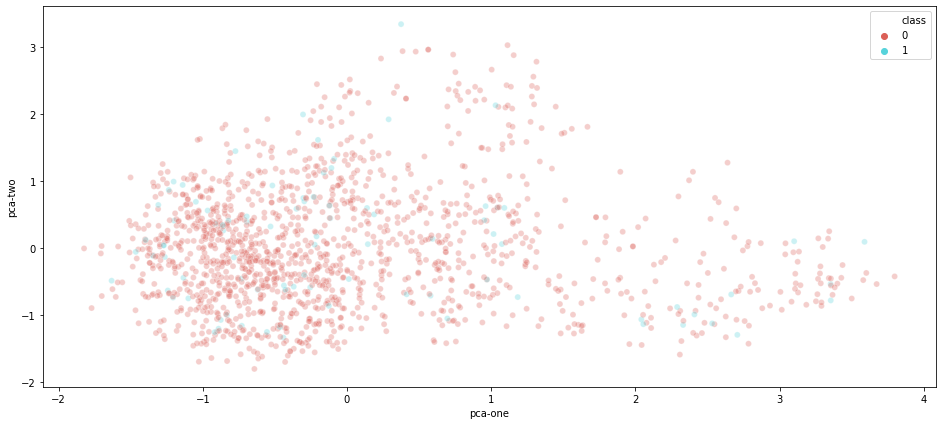

In [29]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

time_start = time.time()
pca_result = pca.fit_transform(data)
df_HDvec['pca-one'] = pca_result[:,0]
df_HDvec['pca-two'] = pca_result[:,1] 
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(16,7))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="class",
    palette=sns.color_palette("hls", 2),
    data= df_HDvec,
    legend="full",
    alpha=0.3,
)

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(data, df_HDvec['class'], test_size=0.1)
print(X_train.shape, Y_train.shape)

(1335, 1027) (1335,)


In [31]:
# A "DMatrix" is XGBOOST's own datatype which is the only way it can interpret data
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

### Section 2 - Training

In [11]:
# Some of the most important parameters. Eta is a kind of learning rate through which we can control overfitting, 
# max_depth refers to the max depth of the 'decision trees' being trained, objective is the loss function, and num_class 
# is the number of classes in the data.
param = {
    'eta': 0.03, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2,
    'eval_metric': 'mlogloss',
    'lambda': 80,
} 

steps = 5000  # The number of training iterations

eval_result = {(D_test,'test'), (D_train,'train')}
'''
From the XGBoost article:
The eta can be thought of more intuitively as a learning rate. Rather than simply adding the predictions of new trees 
to the ensemble with full weight, the eta will be multiplied by the residuals being adding to reduce their weight. This 
effectively reduces the complexity of the overall model.

Other params:
The gamma parameter can also help with controlling overfitting. It specifies the minimum reduction in the loss required
to make a further partition on a leaf node of the tree. I.e if creating a new node doesn’t reduce the loss by a certain 
amount, then we won’t create it at all.

The booster parameter allows you to set the type of model you will use when building the ensemble. 
The default is gbtree which builds an ensemble of decision trees. If your data isn’t too complicated, you can go with the 
faster and simpler gblinear option which builds an ensemble of linear models.
''';

In [12]:
import time

startTime = time.time()
model = xgb.train(param, D_train, steps, eval_result)
print("XGBoost Done! Time Elapsed: {} seconds".format(time.time()-startTime))

[0]	test-mlogloss:0.66744	train-mlogloss:0.66790
[1]	test-mlogloss:0.64305	train-mlogloss:0.64394
[2]	test-mlogloss:0.61989	train-mlogloss:0.62118
[3]	test-mlogloss:0.59788	train-mlogloss:0.59952
[4]	test-mlogloss:0.57692	train-mlogloss:0.57891
[5]	test-mlogloss:0.55695	train-mlogloss:0.55926
[6]	test-mlogloss:0.53791	train-mlogloss:0.54052
[7]	test-mlogloss:0.51973	train-mlogloss:0.52262
[8]	test-mlogloss:0.50237	train-mlogloss:0.50551
[9]	test-mlogloss:0.48577	train-mlogloss:0.48915
[10]	test-mlogloss:0.46989	train-mlogloss:0.47350
[11]	test-mlogloss:0.45469	train-mlogloss:0.45850
[12]	test-mlogloss:0.44013	train-mlogloss:0.44413
[13]	test-mlogloss:0.42617	train-mlogloss:0.43036
[14]	test-mlogloss:0.41278	train-mlogloss:0.41713
[15]	test-mlogloss:0.39993	train-mlogloss:0.40444
[16]	test-mlogloss:0.38759	train-mlogloss:0.39225
[17]	test-mlogloss:0.37574	train-mlogloss:0.38054
[18]	test-mlogloss:0.36435	train-mlogloss:0.36928
[19]	test-mlogloss:0.35340	train-mlogloss:0.35844
[20]	test-

[163]	test-mlogloss:0.02378	train-mlogloss:0.02726
[164]	test-mlogloss:0.02353	train-mlogloss:0.02699
[165]	test-mlogloss:0.02329	train-mlogloss:0.02673
[166]	test-mlogloss:0.02306	train-mlogloss:0.02648
[167]	test-mlogloss:0.02283	train-mlogloss:0.02623
[168]	test-mlogloss:0.02260	train-mlogloss:0.02599
[169]	test-mlogloss:0.02237	train-mlogloss:0.02574
[170]	test-mlogloss:0.02216	train-mlogloss:0.02551
[171]	test-mlogloss:0.02194	train-mlogloss:0.02527
[172]	test-mlogloss:0.02173	train-mlogloss:0.02504
[173]	test-mlogloss:0.02152	train-mlogloss:0.02482
[174]	test-mlogloss:0.02131	train-mlogloss:0.02459
[175]	test-mlogloss:0.02111	train-mlogloss:0.02437
[176]	test-mlogloss:0.02091	train-mlogloss:0.02416
[177]	test-mlogloss:0.02071	train-mlogloss:0.02394
[178]	test-mlogloss:0.02052	train-mlogloss:0.02373
[179]	test-mlogloss:0.02033	train-mlogloss:0.02353
[180]	test-mlogloss:0.02014	train-mlogloss:0.02332
[181]	test-mlogloss:0.01996	train-mlogloss:0.02312
[182]	test-mlogloss:0.01978	tra

[324]	test-mlogloss:0.00813	train-mlogloss:0.00988
[325]	test-mlogloss:0.00809	train-mlogloss:0.00983
[326]	test-mlogloss:0.00806	train-mlogloss:0.00979
[327]	test-mlogloss:0.00802	train-mlogloss:0.00975
[328]	test-mlogloss:0.00799	train-mlogloss:0.00971
[329]	test-mlogloss:0.00795	train-mlogloss:0.00967
[330]	test-mlogloss:0.00792	train-mlogloss:0.00963
[331]	test-mlogloss:0.00788	train-mlogloss:0.00959
[332]	test-mlogloss:0.00785	train-mlogloss:0.00955
[333]	test-mlogloss:0.00782	train-mlogloss:0.00951
[334]	test-mlogloss:0.00778	train-mlogloss:0.00948
[335]	test-mlogloss:0.00775	train-mlogloss:0.00944
[336]	test-mlogloss:0.00772	train-mlogloss:0.00940
[337]	test-mlogloss:0.00768	train-mlogloss:0.00936
[338]	test-mlogloss:0.00765	train-mlogloss:0.00932
[339]	test-mlogloss:0.00762	train-mlogloss:0.00928
[340]	test-mlogloss:0.00759	train-mlogloss:0.00925
[341]	test-mlogloss:0.00756	train-mlogloss:0.00921
[342]	test-mlogloss:0.00753	train-mlogloss:0.00918
[343]	test-mlogloss:0.00749	tra

[485]	test-mlogloss:0.00468	train-mlogloss:0.00580
[486]	test-mlogloss:0.00467	train-mlogloss:0.00579
[487]	test-mlogloss:0.00466	train-mlogloss:0.00577
[488]	test-mlogloss:0.00464	train-mlogloss:0.00576
[489]	test-mlogloss:0.00463	train-mlogloss:0.00574
[490]	test-mlogloss:0.00462	train-mlogloss:0.00573
[491]	test-mlogloss:0.00461	train-mlogloss:0.00571
[492]	test-mlogloss:0.00459	train-mlogloss:0.00570
[493]	test-mlogloss:0.00458	train-mlogloss:0.00568
[494]	test-mlogloss:0.00457	train-mlogloss:0.00567
[495]	test-mlogloss:0.00456	train-mlogloss:0.00565
[496]	test-mlogloss:0.00455	train-mlogloss:0.00564
[497]	test-mlogloss:0.00453	train-mlogloss:0.00562
[498]	test-mlogloss:0.00452	train-mlogloss:0.00561
[499]	test-mlogloss:0.00451	train-mlogloss:0.00560
[500]	test-mlogloss:0.00450	train-mlogloss:0.00558
[501]	test-mlogloss:0.00449	train-mlogloss:0.00557
[502]	test-mlogloss:0.00447	train-mlogloss:0.00555
[503]	test-mlogloss:0.00446	train-mlogloss:0.00554
[504]	test-mlogloss:0.00445	tra

[646]	test-mlogloss:0.00325	train-mlogloss:0.00406
[647]	test-mlogloss:0.00324	train-mlogloss:0.00405
[648]	test-mlogloss:0.00324	train-mlogloss:0.00404
[649]	test-mlogloss:0.00323	train-mlogloss:0.00404
[650]	test-mlogloss:0.00322	train-mlogloss:0.00403
[651]	test-mlogloss:0.00322	train-mlogloss:0.00402
[652]	test-mlogloss:0.00321	train-mlogloss:0.00402
[653]	test-mlogloss:0.00320	train-mlogloss:0.00401
[654]	test-mlogloss:0.00320	train-mlogloss:0.00400
[655]	test-mlogloss:0.00319	train-mlogloss:0.00399
[656]	test-mlogloss:0.00319	train-mlogloss:0.00398
[657]	test-mlogloss:0.00318	train-mlogloss:0.00398
[658]	test-mlogloss:0.00317	train-mlogloss:0.00397
[659]	test-mlogloss:0.00317	train-mlogloss:0.00396
[660]	test-mlogloss:0.00316	train-mlogloss:0.00396
[661]	test-mlogloss:0.00316	train-mlogloss:0.00395
[662]	test-mlogloss:0.00315	train-mlogloss:0.00394
[663]	test-mlogloss:0.00314	train-mlogloss:0.00393
[664]	test-mlogloss:0.00314	train-mlogloss:0.00393
[665]	test-mlogloss:0.00313	tra

[807]	test-mlogloss:0.00247	train-mlogloss:0.00311
[808]	test-mlogloss:0.00247	train-mlogloss:0.00310
[809]	test-mlogloss:0.00247	train-mlogloss:0.00310
[810]	test-mlogloss:0.00246	train-mlogloss:0.00310
[811]	test-mlogloss:0.00246	train-mlogloss:0.00309
[812]	test-mlogloss:0.00246	train-mlogloss:0.00309
[813]	test-mlogloss:0.00245	train-mlogloss:0.00308
[814]	test-mlogloss:0.00245	train-mlogloss:0.00308
[815]	test-mlogloss:0.00245	train-mlogloss:0.00307
[816]	test-mlogloss:0.00244	train-mlogloss:0.00307
[817]	test-mlogloss:0.00244	train-mlogloss:0.00306
[818]	test-mlogloss:0.00243	train-mlogloss:0.00306
[819]	test-mlogloss:0.00243	train-mlogloss:0.00305
[820]	test-mlogloss:0.00243	train-mlogloss:0.00305
[821]	test-mlogloss:0.00242	train-mlogloss:0.00305
[822]	test-mlogloss:0.00242	train-mlogloss:0.00304
[823]	test-mlogloss:0.00242	train-mlogloss:0.00304
[824]	test-mlogloss:0.00241	train-mlogloss:0.00303
[825]	test-mlogloss:0.00241	train-mlogloss:0.00303
[826]	test-mlogloss:0.00241	tra

[968]	test-mlogloss:0.00199	train-mlogloss:0.00251
[969]	test-mlogloss:0.00199	train-mlogloss:0.00251
[970]	test-mlogloss:0.00199	train-mlogloss:0.00251
[971]	test-mlogloss:0.00199	train-mlogloss:0.00250
[972]	test-mlogloss:0.00198	train-mlogloss:0.00250
[973]	test-mlogloss:0.00198	train-mlogloss:0.00250
[974]	test-mlogloss:0.00198	train-mlogloss:0.00249
[975]	test-mlogloss:0.00198	train-mlogloss:0.00249
[976]	test-mlogloss:0.00197	train-mlogloss:0.00249
[977]	test-mlogloss:0.00197	train-mlogloss:0.00248
[978]	test-mlogloss:0.00197	train-mlogloss:0.00248
[979]	test-mlogloss:0.00197	train-mlogloss:0.00248
[980]	test-mlogloss:0.00197	train-mlogloss:0.00248
[981]	test-mlogloss:0.00196	train-mlogloss:0.00247
[982]	test-mlogloss:0.00196	train-mlogloss:0.00247
[983]	test-mlogloss:0.00196	train-mlogloss:0.00247
[984]	test-mlogloss:0.00196	train-mlogloss:0.00247
[985]	test-mlogloss:0.00195	train-mlogloss:0.00246
[986]	test-mlogloss:0.00195	train-mlogloss:0.00246
[987]	test-mlogloss:0.00195	tra

[1127]	test-mlogloss:0.00167	train-mlogloss:0.00211
[1128]	test-mlogloss:0.00167	train-mlogloss:0.00211
[1129]	test-mlogloss:0.00167	train-mlogloss:0.00211
[1130]	test-mlogloss:0.00167	train-mlogloss:0.00210
[1131]	test-mlogloss:0.00166	train-mlogloss:0.00210
[1132]	test-mlogloss:0.00166	train-mlogloss:0.00210
[1133]	test-mlogloss:0.00166	train-mlogloss:0.00210
[1134]	test-mlogloss:0.00166	train-mlogloss:0.00209
[1135]	test-mlogloss:0.00166	train-mlogloss:0.00209
[1136]	test-mlogloss:0.00166	train-mlogloss:0.00209
[1137]	test-mlogloss:0.00165	train-mlogloss:0.00209
[1138]	test-mlogloss:0.00165	train-mlogloss:0.00209
[1139]	test-mlogloss:0.00165	train-mlogloss:0.00208
[1140]	test-mlogloss:0.00165	train-mlogloss:0.00208
[1141]	test-mlogloss:0.00165	train-mlogloss:0.00208
[1142]	test-mlogloss:0.00164	train-mlogloss:0.00208
[1143]	test-mlogloss:0.00164	train-mlogloss:0.00208
[1144]	test-mlogloss:0.00164	train-mlogloss:0.00207
[1145]	test-mlogloss:0.00164	train-mlogloss:0.00207
[1146]	test-

[1285]	test-mlogloss:0.00144	train-mlogloss:0.00182
[1286]	test-mlogloss:0.00144	train-mlogloss:0.00182
[1287]	test-mlogloss:0.00143	train-mlogloss:0.00181
[1288]	test-mlogloss:0.00143	train-mlogloss:0.00181
[1289]	test-mlogloss:0.00143	train-mlogloss:0.00181
[1290]	test-mlogloss:0.00143	train-mlogloss:0.00181
[1291]	test-mlogloss:0.00143	train-mlogloss:0.00181
[1292]	test-mlogloss:0.00143	train-mlogloss:0.00181
[1293]	test-mlogloss:0.00143	train-mlogloss:0.00180
[1294]	test-mlogloss:0.00143	train-mlogloss:0.00180
[1295]	test-mlogloss:0.00142	train-mlogloss:0.00180
[1296]	test-mlogloss:0.00142	train-mlogloss:0.00180
[1297]	test-mlogloss:0.00142	train-mlogloss:0.00180
[1298]	test-mlogloss:0.00142	train-mlogloss:0.00180
[1299]	test-mlogloss:0.00142	train-mlogloss:0.00179
[1300]	test-mlogloss:0.00142	train-mlogloss:0.00179
[1301]	test-mlogloss:0.00142	train-mlogloss:0.00179
[1302]	test-mlogloss:0.00142	train-mlogloss:0.00179
[1303]	test-mlogloss:0.00141	train-mlogloss:0.00179
[1304]	test-

[1443]	test-mlogloss:0.00126	train-mlogloss:0.00160
[1444]	test-mlogloss:0.00126	train-mlogloss:0.00159
[1445]	test-mlogloss:0.00126	train-mlogloss:0.00159
[1446]	test-mlogloss:0.00126	train-mlogloss:0.00159
[1447]	test-mlogloss:0.00126	train-mlogloss:0.00159
[1448]	test-mlogloss:0.00126	train-mlogloss:0.00159
[1449]	test-mlogloss:0.00125	train-mlogloss:0.00159
[1450]	test-mlogloss:0.00125	train-mlogloss:0.00159
[1451]	test-mlogloss:0.00125	train-mlogloss:0.00159
[1452]	test-mlogloss:0.00125	train-mlogloss:0.00158
[1453]	test-mlogloss:0.00125	train-mlogloss:0.00158
[1454]	test-mlogloss:0.00125	train-mlogloss:0.00158
[1455]	test-mlogloss:0.00125	train-mlogloss:0.00158
[1456]	test-mlogloss:0.00125	train-mlogloss:0.00158
[1457]	test-mlogloss:0.00125	train-mlogloss:0.00158
[1458]	test-mlogloss:0.00125	train-mlogloss:0.00158
[1459]	test-mlogloss:0.00125	train-mlogloss:0.00158
[1460]	test-mlogloss:0.00124	train-mlogloss:0.00158
[1461]	test-mlogloss:0.00124	train-mlogloss:0.00157
[1462]	test-

[1601]	test-mlogloss:0.00112	train-mlogloss:0.00142
[1602]	test-mlogloss:0.00112	train-mlogloss:0.00142
[1603]	test-mlogloss:0.00112	train-mlogloss:0.00142
[1604]	test-mlogloss:0.00112	train-mlogloss:0.00142
[1605]	test-mlogloss:0.00112	train-mlogloss:0.00142
[1606]	test-mlogloss:0.00112	train-mlogloss:0.00142
[1607]	test-mlogloss:0.00112	train-mlogloss:0.00142
[1608]	test-mlogloss:0.00112	train-mlogloss:0.00142
[1609]	test-mlogloss:0.00112	train-mlogloss:0.00141
[1610]	test-mlogloss:0.00112	train-mlogloss:0.00141
[1611]	test-mlogloss:0.00111	train-mlogloss:0.00141
[1612]	test-mlogloss:0.00111	train-mlogloss:0.00141
[1613]	test-mlogloss:0.00111	train-mlogloss:0.00141
[1614]	test-mlogloss:0.00111	train-mlogloss:0.00141
[1615]	test-mlogloss:0.00111	train-mlogloss:0.00141
[1616]	test-mlogloss:0.00111	train-mlogloss:0.00141
[1617]	test-mlogloss:0.00111	train-mlogloss:0.00141
[1618]	test-mlogloss:0.00111	train-mlogloss:0.00140
[1619]	test-mlogloss:0.00111	train-mlogloss:0.00140
[1620]	test-

[1759]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1760]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1761]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1762]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1763]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1764]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1765]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1766]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1767]	test-mlogloss:0.00101	train-mlogloss:0.00128
[1768]	test-mlogloss:0.00101	train-mlogloss:0.00127
[1769]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1770]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1771]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1772]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1773]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1774]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1775]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1776]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1777]	test-mlogloss:0.00100	train-mlogloss:0.00127
[1778]	test-

[1917]	test-mlogloss:0.00092	train-mlogloss:0.00117
[1918]	test-mlogloss:0.00092	train-mlogloss:0.00117
[1919]	test-mlogloss:0.00092	train-mlogloss:0.00117
[1920]	test-mlogloss:0.00092	train-mlogloss:0.00116
[1921]	test-mlogloss:0.00092	train-mlogloss:0.00116
[1922]	test-mlogloss:0.00092	train-mlogloss:0.00116
[1923]	test-mlogloss:0.00092	train-mlogloss:0.00116
[1924]	test-mlogloss:0.00092	train-mlogloss:0.00116
[1925]	test-mlogloss:0.00092	train-mlogloss:0.00116
[1926]	test-mlogloss:0.00091	train-mlogloss:0.00116
[1927]	test-mlogloss:0.00091	train-mlogloss:0.00116
[1928]	test-mlogloss:0.00091	train-mlogloss:0.00116
[1929]	test-mlogloss:0.00091	train-mlogloss:0.00116
[1930]	test-mlogloss:0.00091	train-mlogloss:0.00116
[1931]	test-mlogloss:0.00091	train-mlogloss:0.00116
[1932]	test-mlogloss:0.00091	train-mlogloss:0.00116
[1933]	test-mlogloss:0.00091	train-mlogloss:0.00115
[1934]	test-mlogloss:0.00091	train-mlogloss:0.00115
[1935]	test-mlogloss:0.00091	train-mlogloss:0.00115
[1936]	test-

[2075]	test-mlogloss:0.00084	train-mlogloss:0.00107
[2076]	test-mlogloss:0.00084	train-mlogloss:0.00107
[2077]	test-mlogloss:0.00084	train-mlogloss:0.00107
[2078]	test-mlogloss:0.00084	train-mlogloss:0.00107
[2079]	test-mlogloss:0.00084	train-mlogloss:0.00107
[2080]	test-mlogloss:0.00084	train-mlogloss:0.00107
[2081]	test-mlogloss:0.00084	train-mlogloss:0.00107
[2082]	test-mlogloss:0.00084	train-mlogloss:0.00107
[2083]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2084]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2085]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2086]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2087]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2088]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2089]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2090]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2091]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2092]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2093]	test-mlogloss:0.00084	train-mlogloss:0.00106
[2094]	test-

[2233]	test-mlogloss:0.00078	train-mlogloss:0.00099
[2234]	test-mlogloss:0.00078	train-mlogloss:0.00099
[2235]	test-mlogloss:0.00078	train-mlogloss:0.00099
[2236]	test-mlogloss:0.00078	train-mlogloss:0.00099
[2237]	test-mlogloss:0.00078	train-mlogloss:0.00099
[2238]	test-mlogloss:0.00078	train-mlogloss:0.00098
[2239]	test-mlogloss:0.00078	train-mlogloss:0.00098
[2240]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2241]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2242]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2243]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2244]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2245]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2246]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2247]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2248]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2249]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2250]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2251]	test-mlogloss:0.00077	train-mlogloss:0.00098
[2252]	test-

[2391]	test-mlogloss:0.00072	train-mlogloss:0.00092
[2392]	test-mlogloss:0.00072	train-mlogloss:0.00092
[2393]	test-mlogloss:0.00072	train-mlogloss:0.00092
[2394]	test-mlogloss:0.00072	train-mlogloss:0.00092
[2395]	test-mlogloss:0.00072	train-mlogloss:0.00092
[2396]	test-mlogloss:0.00072	train-mlogloss:0.00092
[2397]	test-mlogloss:0.00072	train-mlogloss:0.00092
[2398]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2399]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2400]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2401]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2402]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2403]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2404]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2405]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2406]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2407]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2408]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2409]	test-mlogloss:0.00072	train-mlogloss:0.00091
[2410]	test-

[2549]	test-mlogloss:0.00067	train-mlogloss:0.00086
[2550]	test-mlogloss:0.00067	train-mlogloss:0.00086
[2551]	test-mlogloss:0.00067	train-mlogloss:0.00086
[2552]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2553]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2554]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2555]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2556]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2557]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2558]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2559]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2560]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2561]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2562]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2563]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2564]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2565]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2566]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2567]	test-mlogloss:0.00067	train-mlogloss:0.00085
[2568]	test-

[2707]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2708]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2709]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2710]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2711]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2712]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2713]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2714]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2715]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2716]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2717]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2718]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2719]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2720]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2721]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2722]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2723]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2724]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2725]	test-mlogloss:0.00063	train-mlogloss:0.00080
[2726]	test-

[2865]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2866]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2867]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2868]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2869]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2870]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2871]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2872]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2873]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2874]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2875]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2876]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2877]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2878]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2879]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2880]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2881]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2882]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2883]	test-mlogloss:0.00060	train-mlogloss:0.00076
[2884]	test-

[3023]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3024]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3025]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3026]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3027]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3028]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3029]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3030]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3031]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3032]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3033]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3034]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3035]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3036]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3037]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3038]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3039]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3040]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3041]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3042]	test-

[3181]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3182]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3183]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3184]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3185]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3186]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3187]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3188]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3189]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3190]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3191]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3192]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3193]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3194]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3195]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3196]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3197]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3198]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3199]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3200]	test-

[3339]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3340]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3341]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3342]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3343]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3344]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3345]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3346]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3347]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3348]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3349]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3350]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3351]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3352]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3353]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3354]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3355]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3356]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3357]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3358]	test-

[3497]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3498]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3499]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3500]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3501]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3502]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3503]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3504]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3505]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3506]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3507]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3508]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3509]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3510]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3511]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3512]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3513]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3514]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3515]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3516]	test-

[3655]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3656]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3657]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3658]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3659]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3660]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3661]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3662]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3663]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3664]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3665]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3666]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3667]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3668]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3669]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3670]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3671]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3672]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3673]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3674]	test-

[3813]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3814]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3815]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3816]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3817]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3818]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3819]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3820]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3821]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3822]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3823]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3824]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3825]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3826]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3827]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3828]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3829]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3830]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3831]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3832]	test-

[3971]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3972]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3973]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3974]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3975]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3976]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3977]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3978]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3979]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3980]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3981]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3982]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3983]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3984]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3985]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3986]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3987]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3988]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3989]	test-mlogloss:0.00060	train-mlogloss:0.00076
[3990]	test-

[4129]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4130]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4131]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4132]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4133]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4134]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4135]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4136]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4137]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4138]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4139]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4140]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4141]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4142]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4143]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4144]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4145]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4146]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4147]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4148]	test-

[4287]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4288]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4289]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4290]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4291]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4292]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4293]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4294]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4295]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4296]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4297]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4298]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4299]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4300]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4301]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4302]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4303]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4304]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4305]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4306]	test-

[4445]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4446]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4447]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4448]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4449]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4450]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4451]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4452]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4453]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4454]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4455]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4456]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4457]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4458]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4459]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4460]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4461]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4462]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4463]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4464]	test-

[4603]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4604]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4605]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4606]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4607]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4608]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4609]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4610]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4611]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4612]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4613]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4614]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4615]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4616]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4617]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4618]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4619]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4620]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4621]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4622]	test-

[4761]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4762]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4763]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4764]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4765]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4766]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4767]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4768]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4769]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4770]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4771]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4772]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4773]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4774]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4775]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4776]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4777]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4778]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4779]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4780]	test-

[4919]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4920]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4921]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4922]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4923]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4924]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4925]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4926]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4927]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4928]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4929]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4930]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4931]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4932]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4933]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4934]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4935]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4936]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4937]	test-mlogloss:0.00060	train-mlogloss:0.00076
[4938]	test-

### Section 3 - Quantitative Analysis

In [13]:
preds = model.predict(D_test)
predicted = np.asarray([np.argmax(line) for line in preds])
actual = Y_test

print(len(predicted))

149


In [14]:
truePos = np.sum((predicted == 1) & (actual == 1))
trueNeg = np.sum((predicted == 0) & (actual == 0))
falsePos = np.sum((predicted == 1) & (actual == 0))
falseNeg = np.sum((predicted == 0) & (actual == 1))

print("True positives = {}".format(truePos))
print("True negatives = {}".format(trueNeg))
print("False positives = {}".format(falsePos))
print("False negatives = {}\n".format(falseNeg))

accuracy = (truePos + trueNeg) / len(predicted)
precision = truePos / (truePos + falsePos)
recall = truePos / (truePos + falseNeg)
F1 = 2 * ((precision * recall) / (precision + recall))

print("Accuracy = {}".format(accuracy))
print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("F1 = {}".format(F1))

True positives = 5
True negatives = 144
False positives = 0
False negatives = 0

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1 = 1.0


In [35]:
# Compute the ROC-AUC score for this model.
from sklearn.metrics import roc_auc_score
y_pred_probs = [np.max(line) for line in preds]
print(roc_auc_score(Y_test, preds[:,0]))

0.537677304964539
